In [1]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import time
from torch import nn
import torch.nn.functional as F
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

from torch.utils.tensorboard import SummaryWriter

from PIL import Image
import ghostipy
from ghostipy.spectral.wavelets import MorseWavelet

In [2]:
# Define path for dataset
dataset_path = "dataset/Data.xlsx"

In [3]:
def get_data(x1, x2, sheet_number):
    """
    Process the excel file to get the right data into dataframes
    """
    xls = pd.ExcelFile(dataset_path)
    df = pd.read_excel(xls, f'Road{sheet_number}')
    df = df.iloc[x1:x2, 2:]
    df.columns = df[:1].squeeze()
    df = df[1:]
    df = df.set_index('Section')
    return df

In [4]:
def drop_na(df1, df2, df3=None):
    df1 = df1.loc[:, df1.columns.notna()]
    df2 = df2.loc[:, df2.columns.notna()]
    
    if df3 is not None:
        df3 = df3.loc[:, df3.columns.notna()]
    
    return df1, df2, df3

In [5]:
uncracked_list = []
cracked_list = []

# Get data from sheet 1
df1 = get_data(4, 51, 1)
df2 = get_data(55, 100, 1)
df3 = get_data(104, 148, 1)

df1, df2, df3 = drop_na(df1, df2, df3)

cracked_list.append(df1.iloc[:14])
uncracked_list.append(df1.iloc[14:46])

cracked_list.append(df2.iloc[:12])
uncracked_list.append(df2.iloc[12:44])

cracked_list.append(df3.iloc[:11])
uncracked_list.append(df3.iloc[11:43])


# Get data from sheet 2
df1 = get_data(4, 89, 2)
df2 = get_data(97, 161, 2)

df_list = [df1, df2]
df1, df2, _ = drop_na(df1, df2)

cracked_list.append(df1.iloc[:28])
uncracked_list.append(df1.iloc[28:84])

cracked_list.append(df2.iloc[:21])
uncracked_list.append(df2.iloc[21:63])

# Get data from sheet 3
df1 = get_data(4, 17, 3)
df2 = get_data(21, 37, 3)
df3 = get_data(39, 60, 3)

df_list = [df1, df2, df3]
df1, df2, df3 = drop_na(df1, df2, df3)

cracked_list.append(df1.iloc[:6])
uncracked_list.append(df1.iloc[6:12])

cracked_list.append(df2.iloc[:6])
uncracked_list.append(df2.iloc[6:15])

cracked_list.append(df3.iloc[:11])
uncracked_list.append(df3.iloc[11:20])

In [6]:
for df in cracked_list:
    df.insert(0, "label", len(df) * ['cracked'], True)
    
for df in uncracked_list:
    df.insert(0, "label", len(df) * ['uncracked'], True)

In [7]:
cracked_list[1]

55,label,0,0.00868055555555556,0.0173611111111111,0.0260416666666667,0.0347222222222222,0.0434027777777778,0.0520833333333333,0.0607638888888889,0.0694444444444445,...,3.91493055555556,3.92361111111111,3.93229166666667,3.94097222222222,3.94965277777778,3.95833333333333,3.96701388888889,3.97569444444444,3.984375,3.99305555555556
Section,,,,,,,,,,,,,,,,,,,,,
1,cracked,-2.48992,-3.21408,1.24992,0.93248,-2.10304,-2.83712,-2.41056,-0.06944,-2.14272,...,2.57920,2.90656,1.16064,-1.24000,-1.12096,0.53568,1.10112,-1.55744,-0.18848,-0.97216
2,cracked,-1.08128,-2.30144,0.52576,2.84704,0.24800,-0.66464,-1.04160,0.80352,0.07936,...,-2.35104,-0.29760,-0.53568,-1.37888,-0.74400,0.47616,-0.17856,-2.56928,-1.03168,1.14080
3,cracked,2.48,-0.64480,-1.03168,1.71616,2.63872,2.18240,0.70432,1.48800,4.06720,...,-0.12896,-1.53760,-2.45024,-0.90272,0.49600,-1.25984,-1.33920,-2.37088,-1.18048,-0.88288
4,cracked,-1.8352,-1.65664,-0.76384,-1.65664,-1.96416,2.10304,3.03552,2.57920,-2.09312,...,-1.69632,-1.81536,-0.88288,0.81344,-0.08928,0.31744,1.70624,2.08320,0.46624,-0.61504
5,cracked,-0.21824,-0.48608,-0.81344,-2.01376,-0.26784,-0.73408,-1.13088,-2.23200,-2.14272,...,-3.42240,1.38880,-0.38688,-2.50976,-0.78368,2.79744,1.86496,-0.79360,-3.62080,0.76384
6,cracked,1.90464,-1.69632,-1.99392,1.35904,1.65664,0.28768,-2.47008,-1.64672,1.62688,...,-1.10112,-1.25984,1.88480,-1.32928,-1.02176,-1.77568,1.96416,1.17056,-0.50592,2.36096
7,cracked,-0.8928,-3.06528,-1.31936,-0.24800,0.09920,-0.60512,-0.43648,0.18848,-1.94432,...,-0.77376,1.48800,3.19424,1.41856,0.36704,-1.18048,-1.84512,1.53760,1.50784,2.45024
8,cracked,-1.4384,0.53568,0.33728,0.17856,-0.02976,0.73408,-0.64480,1.42848,1.13088,...,-0.93248,1.96416,1.26976,1.31936,0.34720,4.35488,2.03360,-1.42848,0.98208,3.11488
9,cracked,-0.28768,-0.81344,-2.75776,-3.15456,0.32736,0.25792,-1.55744,-0.78368,2.48992,...,-2.28160,0.27776,2.47008,3.58112,-0.44640,-2.51968,0.02976,0.45632,-0.09920,1.11104


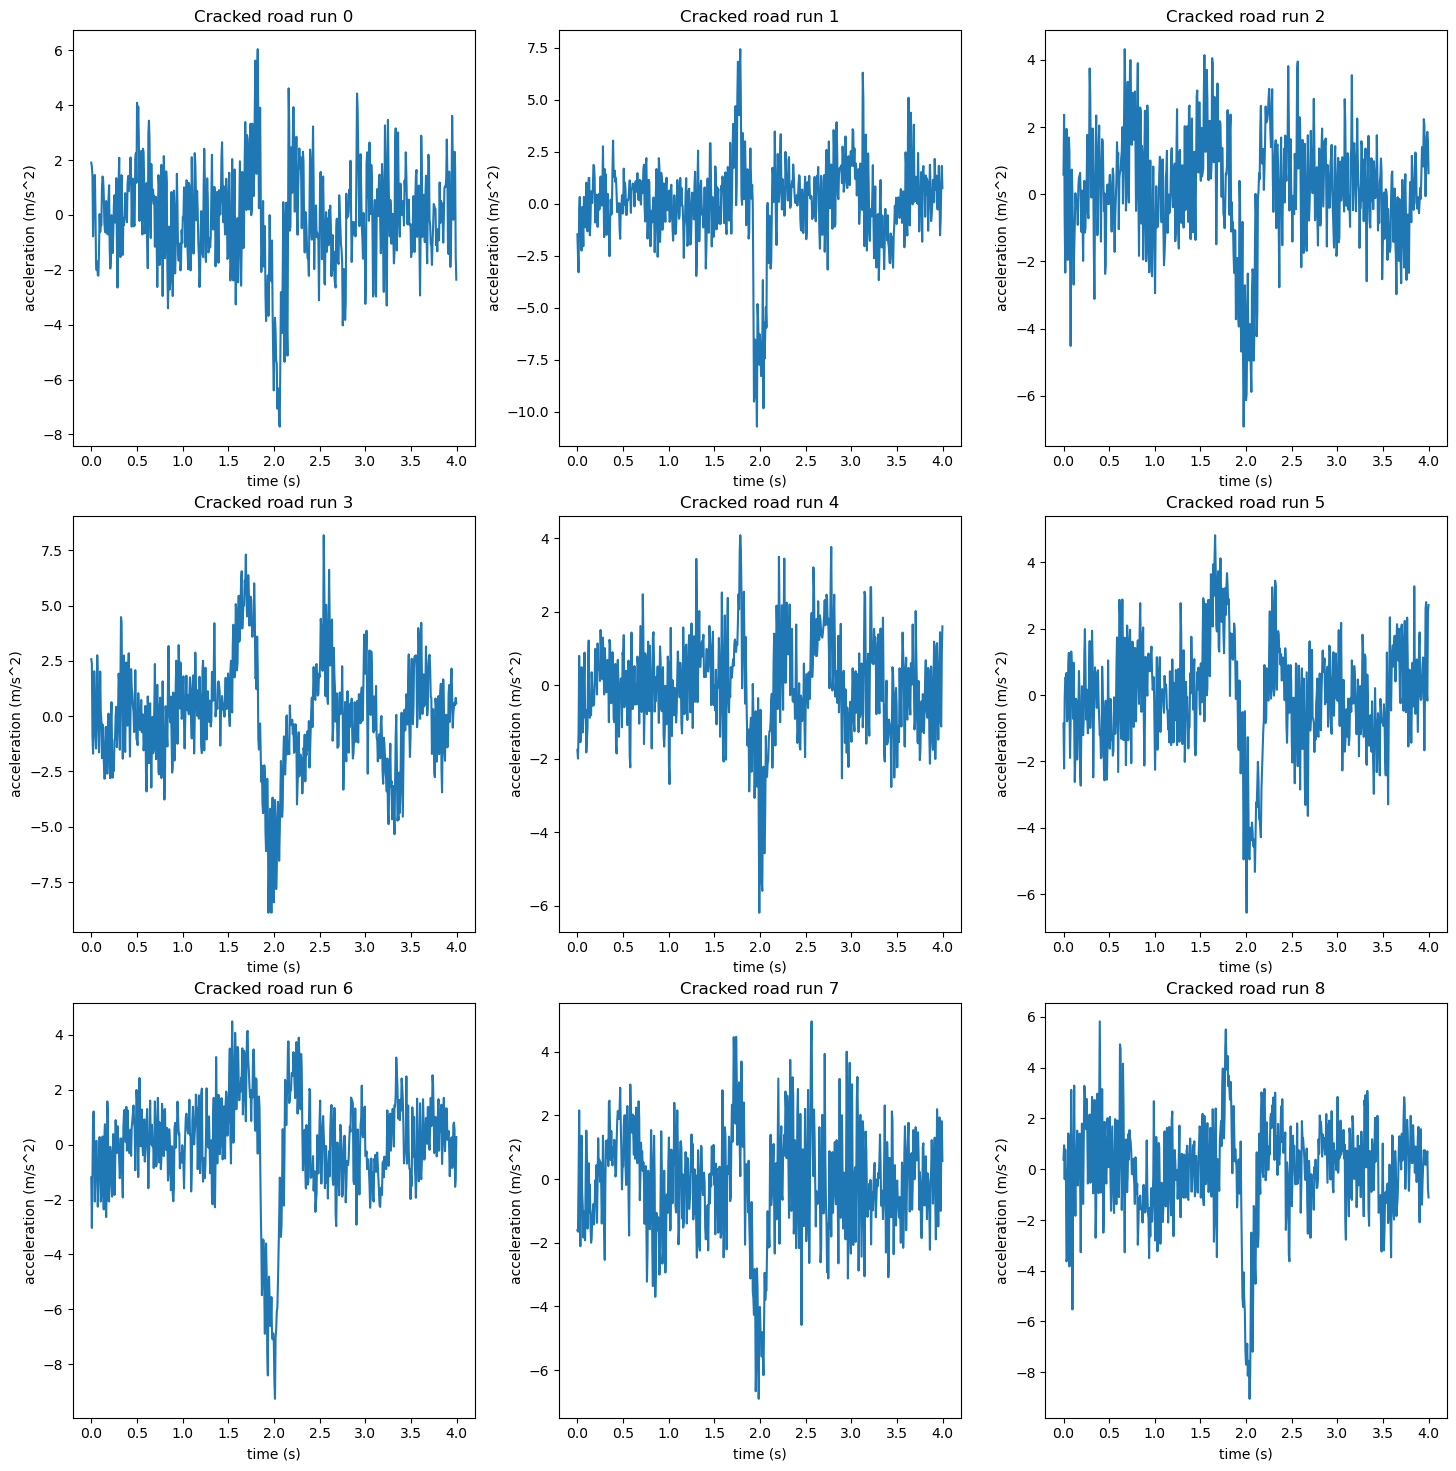

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
fig.tight_layout(pad=3.0)
time_stamp = list(cracked_list[0].columns)[1:]
count = 0
for i in range(3):
    for j in range(3):
        acceleration = list(cracked_list[0].iloc[j + count])[1:]
        ax[i, j].set_title(f'Cracked road run {j + count}')
        ax[i, j].set_xlabel('time (s)')
        ax[i, j].set_ylabel('acceleration (m/s^2)')
        ax[i, j].plot(time_stamp, acceleration)
    count += 3
plt.show()

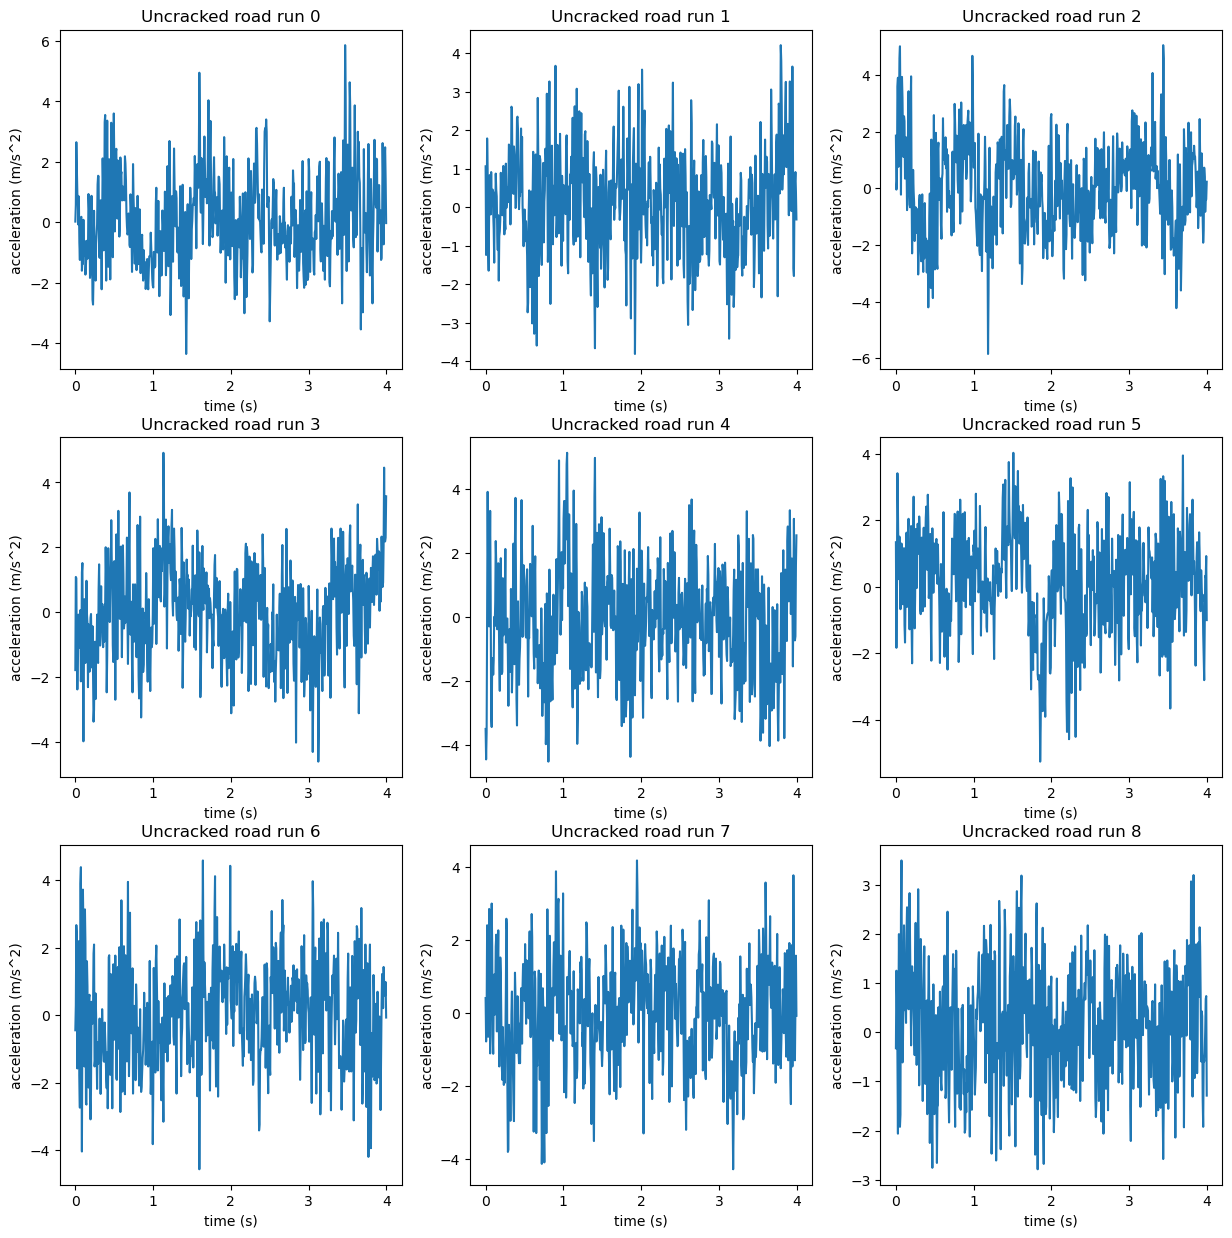

In [9]:
fig, ax = plt.subplots(3, 3, figsize=(15, 15))
time_stamp = list(uncracked_list[0].columns)[1:]
count = 0
for i in range(3):
    for j in range(3):
        acceleration = list(uncracked_list[0].iloc[j + count])[1:]
        ax[i, j].set_title(f'Uncracked road run {j + count}')
        ax[i, j].set_xlabel('time (s)')
        ax[i, j].set_ylabel('acceleration (m/s^2)')
        ax[i, j].plot(time_stamp, acceleration)
    count += 3
plt.show()

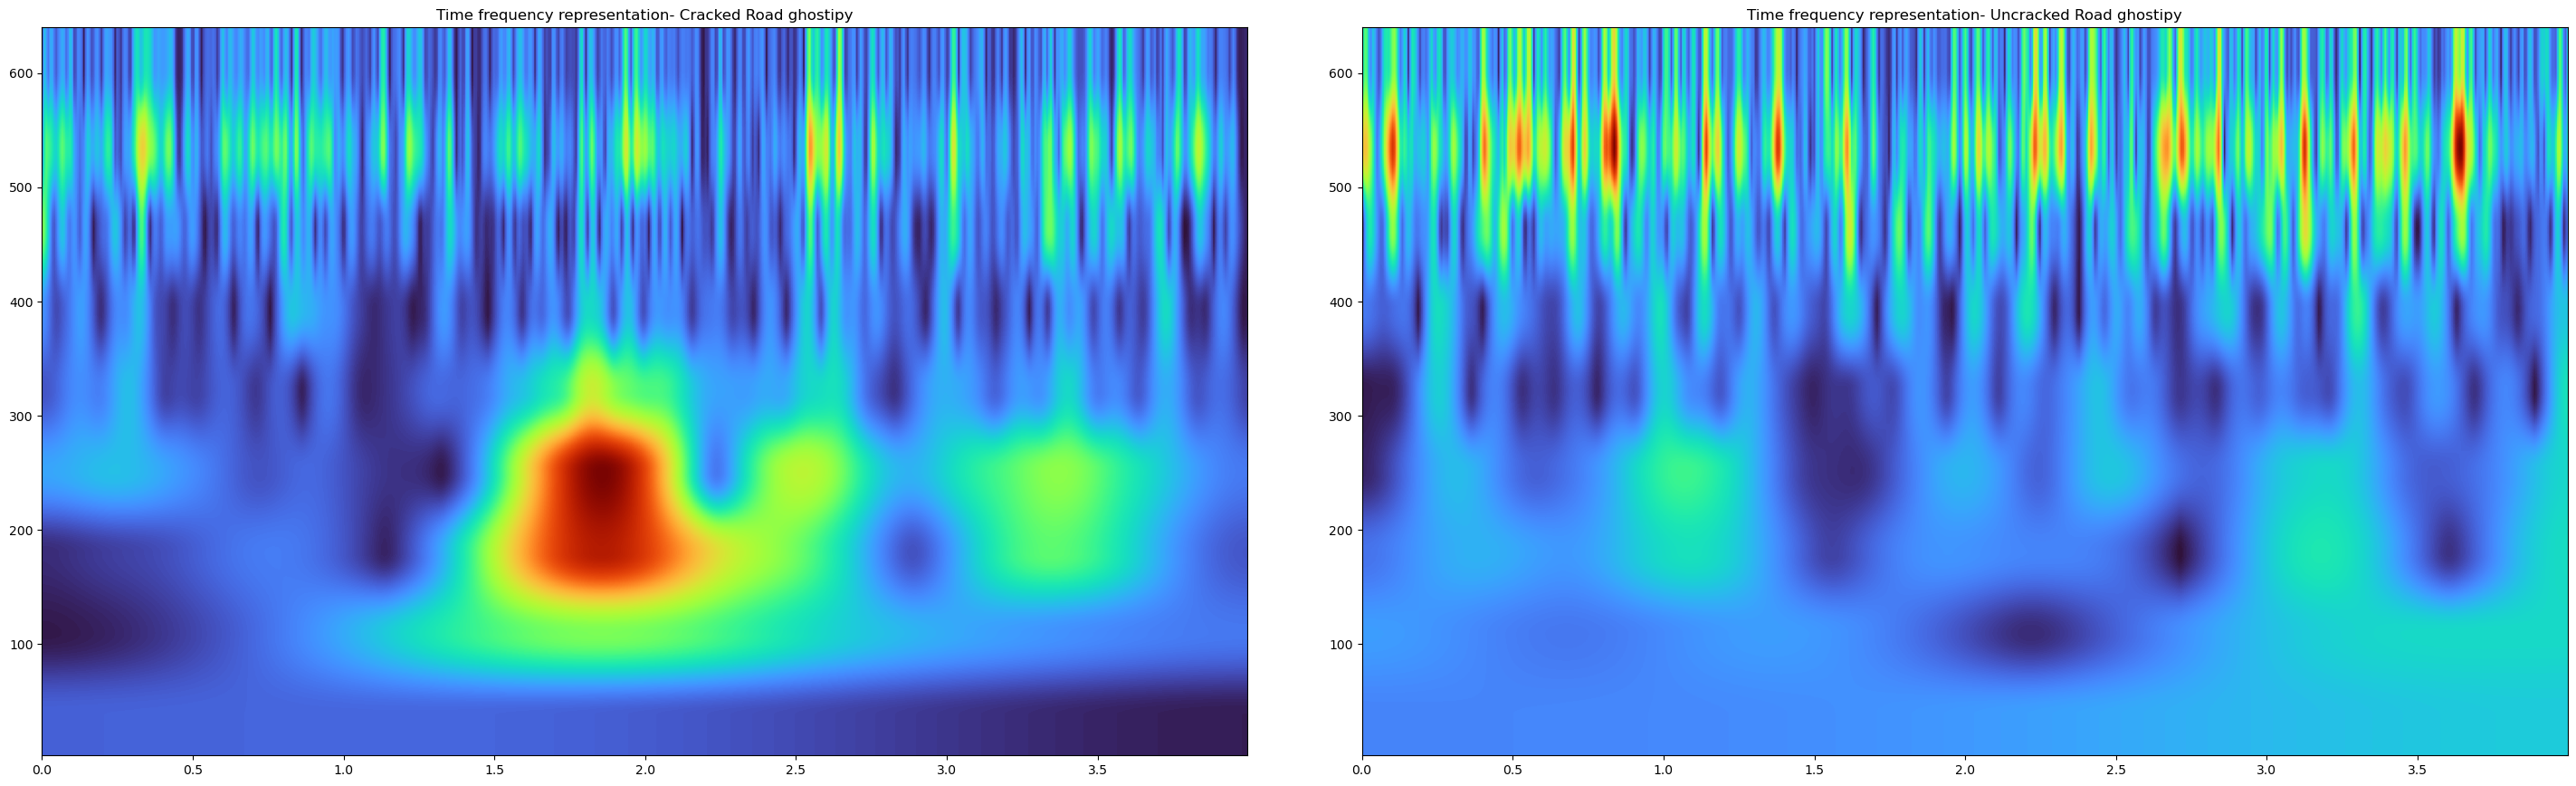

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(30, 10))
fig.tight_layout(pad=6.0)

uncracked_time_stamp = list(uncracked_list[0].columns)[1:]
cracked_time_stamp = list(cracked_list[0].columns)[1:]

run_number = 3 # The acceleration series number 

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = cracked_list[0].iloc[run_number][1:]
Wx, scale, freq, *_  = ghostipy.spectral.cwt(x, fs=1280, wavelet=gmw, voices_per_octave=1)
ax[0].set_title('Time frequency representation- Cracked Road ghostipy')
ax[0].imshow(np.abs(Wx), aspect='auto', cmap='turbo', 
               extent=[cracked_time_stamp[0], cracked_time_stamp[-1], freq[-1], freq[0]])

gmw = MorseWavelet(gamma=3, beta=1.3333)
x = uncracked_list[0].iloc[run_number][1:]
Wx, scale, freq, *_ = ghostipy.spectral.cwt(x, fs=1280, wavelet=gmw, voices_per_octave=1)
ax[1].set_title('Time frequency representation- Uncracked Road ghostipy')
ax[1].imshow(np.abs(Wx), aspect='auto', cmap='turbo', 
               extent=[uncracked_time_stamp[0], uncracked_time_stamp[-1], freq[-1], freq[0]])

In [11]:
## Uncomment to save cracked scalograms from the dataset

# gmw = MorseWavelet(gamma=3, beta=1.3333)
# img_count = 0

# for i, acceleration_df in enumerate(cracked_list):
#     print(f'Processing df number {i}:')
#     cracked_time_stamp = list(cracked_list[i].columns)[1:]
    
#     for row in range(len(acceleration_df)):
#         img_count = img_count + 1
#         x = list(acceleration_df.iloc[row][1:])
#         x = np.array(x)
#         Wx, scale, freq, *_  = ghostipy.spectral.cwt(x, fs=1280, wavelet=gmw, voices_per_octave=1)
#         plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')    
#         plt.axis('off')
#         plt.savefig(f'./gmw_scalograms/gmw_scalogram_cracked_{img_count}.png')
#         print(f'Processed row number {row}')

In [12]:
## Uncomment to save uncracked scalograms from the dataset

# gmw = MorseWavelet(gamma=3, beta=1.3333)
# img_count = 0

# for i, acceleration_df in enumerate(uncracked_list):
#     print(f'Processing df number {i}:')
#     uncracked_time_stamp = list(uncracked_list[i].columns)[1:]
    
#     for row in range(len(acceleration_df)):
#         img_count = img_count + 1
#         x = list(acceleration_df.iloc[row][1:])
#         x = np.array(x)
#         Wx, scale, freq, *_  = ghostipy.spectral.cwt(x, fs=1280, wavelet=gmw, voices_per_octave=1)
#         plt.imshow(np.abs(Wx), aspect='auto', cmap='turbo')    
#         plt.axis('off')
#         plt.savefig(f'./gmw_scalograms/gmw_scalogram_uncracked_{img_count}.png')
#         print(f'Processed row number {row}')

In [13]:
# Custom dataset 

class CustomDataset(Dataset):
    def __init__(self,  transform=False):
        self.imgs_path = "gmw_scalograms/"
        file_list = glob.glob(self.imgs_path + "*")
        self.data = []
        for class_path in file_list:
            class_name = class_path.split("/")[-1]
            for img_path in glob.glob(class_path + "/*.png"):
                self.data.append([img_path, class_name])
        self.class_map = {"cracked" : 0., "uncracked": 1.}
        self.transform = transform
   
    def __len__(self):
        return len(self.data)    

    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        # img = cv2.imread(img_path)
        class_id = self.class_map[class_name]
        image = Image.open(img_path).convert('RGB')
        class_id = torch.tensor([class_id])
        
        if self.transform is not None:
            img_tensor = self.transform(image)
            
        return img_tensor, class_id

In [14]:
batch_size = 256
class_map = {0.: "cracked", 1.: "uncracked"}

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

crack_dataset = CustomDataset(transform=preprocess)
train_size = int(0.8 * len(crack_dataset))
valid_size = len(crack_dataset) - train_size

train_dataset, test_dataset = random_split(crack_dataset, [train_size, valid_size])

# dataloader with a batch size of 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


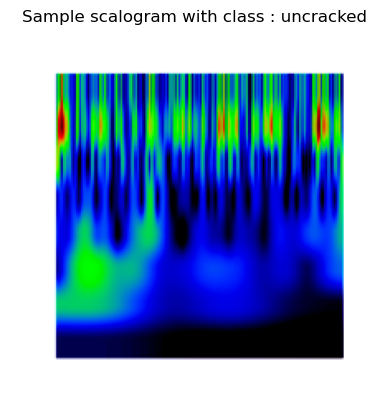

In [15]:
plt.imshow(crack_dataset[0][0].permute(1, 2, 0))
plt.title(f'Sample scalogram with class : {class_map[crack_dataset[0][1].item()]}')
plt.axis('off')
plt.show()

In [16]:
class googlenet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        googlenet = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

        # Delete the last fc Layer (Classfication Head) from Googlenet.
        modules = list(googlenet.children())[:-1] # delete the last fc layer.
        self.googlenet = nn.Sequential(*modules) 
        self.fc = nn.Linear(in_features=googlenet.fc.in_features, out_features=num_classes) 
        
    def forward(self, images):
        with torch.no_grad():
            googlenet_output = self.googlenet(images) 
        
        googlenet_output = googlenet_output.reshape(googlenet_output.size(0), -1)
        logits = self.fc(googlenet_output)
        output = F.sigmoid(logits)
        
        return output

In [17]:
class squeezenet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.squeezenet = torch.hub.load('pytorch/vision:v0.10.0', 'squeezenet1_0', pretrained=True)
        self.squeezenet.classifier._modules["1"] = nn.Conv2d(512, 1, kernel_size=(1, 1))
        self.squeezenet.num_classes = num_classes
        
        for param in self.squeezenet.parameters():
            param.requires_grad = False
        for param in self.squeezenet.classifier.parameters():
            param.requires_grad = True
        
    def forward(self, images):
        squeezenet_output = self.squeezenet(images) 
    
        squeezenet_output = squeezenet_output.reshape(squeezenet_output.size(0), -1)
        output = F.sigmoid(squeezenet_output)
        
        return output

In [22]:
class resnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        resnet = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

        # Delete the last fc Layer (Classfication Head) from Resnet.
        modules = list(resnet.children())[:-1] # delete the last fc layer.
        self.resnet = nn.Sequential(*modules) 
        self.fc = nn.Linear(in_features=resnet.fc.in_features, out_features=num_classes) 
        
    def forward(self, images):
        with torch.no_grad():
            resnet_output = self.resnet(images) 
        
        resnet_output = resnet_output.reshape(resnet_output.size(0), -1)
        logits = self.fc(resnet_output)
        output = F.sigmoid(logits)
        
        return output

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_epochs = 1000
num_batches = len(train_dataloader) 
learning_rate = 0.0001

# Choose one model
# Chose from Googlenet, Squeezenet and Resnet
model_name = "Squeezenet" 
model_dict = {
    "Googlenet": googlenet(num_classes=1).to(device),
    "Squeezenet": squeezenet(num_classes=1).to(device),
    "Resnet": resnet(num_classes=1).to(device)
}

model = model_dict[model_name]

# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCELoss()

Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rishabrs/miniconda3/envs/pothole/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0
/home/rishabrs/miniconda3/envs/pothole/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `w

In [127]:
running_loss = 0.

start_epoch = 1
step = 0
start_at_checkpoint = True 
checkpoint_path = "./model_checkpoints/"

writer = SummaryWriter(f"runs/{model_name}")


if(start_at_checkpoint):
    start_epoch = 501 # The start epoch of the model you want to load.
    step = start_epoch
    resume_epoch = start_epoch-1
    checkpoint = torch.load(f'{checkpoint_path}/{model_name}/{model_name}-finetune-adam-epoch_{resume_epoch}')
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

model.train()
    
for epoch in range(num_epochs-start_epoch+1):
    for i, (image_batch, label_batch) in enumerate(train_dataloader):
        image_batch = image_batch.to(device)        
        label_batch = label_batch.to(device)
        
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(image_batch)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, label_batch)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
        running_loss +=loss.item()

    # Gather data and report
    print('epoch {} loss: {}'.format(epoch+start_epoch, running_loss/num_batches))
    writer.add_scalar("Training loss Adam", running_loss/num_batches, global_step=step)
    step += 1
    running_loss = 0.0
    
    if (epoch+1)%50 == 0:
        checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }
        torch.save(checkpoint, f'{checkpoint_path}/{model_name}/{model_name}-finetune-adam-epoch_{epoch+start_epoch}')

epoch 501 loss: 0.44077275693416595
epoch 502 loss: 0.45415063202381134
epoch 503 loss: 0.4493251144886017
epoch 504 loss: 0.434263214468956
epoch 505 loss: 0.45741690695285797
epoch 506 loss: 0.44752591848373413
epoch 507 loss: 0.44407761096954346
epoch 508 loss: 0.4434957504272461
epoch 509 loss: 0.4490346312522888
epoch 510 loss: 0.4595068693161011
epoch 511 loss: 0.4484451562166214
epoch 512 loss: 0.4490687698125839
epoch 513 loss: 0.44603419303894043
epoch 514 loss: 0.4421868473291397
epoch 515 loss: 0.4493989199399948
epoch 516 loss: 0.45453135669231415
epoch 517 loss: 0.43982528150081635
epoch 518 loss: 0.45111653208732605
epoch 519 loss: 0.44408053159713745
epoch 520 loss: 0.4346316158771515
epoch 521 loss: 0.45128796994686127
epoch 522 loss: 0.4342368394136429
epoch 523 loss: 0.430796280503273
epoch 524 loss: 0.44178129732608795
epoch 525 loss: 0.43923020362854004
epoch 526 loss: 0.4415307343006134
epoch 527 loss: 0.43976011872291565
epoch 528 loss: 0.4275064617395401
epoch 52

KeyboardInterrupt: 

In [48]:
total_correct = 0
total_samples = 0
model_num = 500

# Choose one model and replace the string model_name
# Chose from Googlenet, Squeezenet and Resnet
model_name = "Resnet" 
model_dict = {
    "Googlenet": googlenet(num_classes=1).to(device),
    "Squeezenet": squeezenet(num_classes=1).to(device),
    "Resnet": resnet(num_classes=1).to(device)
}

print(model_name)
model = model_dict[model_name]

checkpoint_path = "./model_checkpoints/"

checkpoint = torch.load(f'{checkpoint_path}/{model_name}/{model_name}-finetune-adam-epoch_{model_num}')
model.load_state_dict(checkpoint['model_state_dict'])

for images, labels in test_dataloader:
    # Move the data to the device (CPU or GPU)
    model.eval()
    labels = labels.to(device)
    
    with torch.no_grad():
        # Forward pass
        since = time.time()
        images = images.to(device)
        outputs = model(images)
        predicted = torch.round(outputs)
        time_elapsed = time.time() - since
            
        # Update the running total of correct predictions and samples
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

# Calculate the accuracy for this epoch
accuracy = 100 * total_correct / total_samples
print(f'Accuracy = {accuracy:.2f}%')
print(f'Inference time = {time_elapsed} for model: {model_name}')

Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0
Using cache found in /home/rishabrs/.cache/torch/hub/pytorch_vision_v0.10.0


Resnet
Accuracy = 95.45%
Inference time = 0.005856037139892578 for model: Resnet


In [43]:
model.eval()
image = next(iter(test_dataloader))[0][0].unsqueeze(0)

with torch.no_grad():
    since = time.time()
    image = image.to(device)
    outputs = model(image)
    predicted = torch.round(outputs)
    time_elapsed = time.time() - since
    
print(f'Inference time = {time_elapsed} for model: {model_name}')

Inference time = 0.0037004947662353516 for model: Resnet
